# Extended Streamflow Prediction forecasts from climatological time series

This notebook shows how to perform a climatological Extended Streamflow Prediction (ESP) forecast, using historical weather as a proxy for future weather. 

The general idea is to initialize the state of the hydrological model to represent current conditions, but instead of using weather forecasts to predict future flows, we run the model with observed, historical weather series from past years. So for example if we have 30 years of weather observations, we get 30 different forecasts. The accuracy of this forecast ensemble can then be evaluated by different probabilistic metrics.

## Connect to remote server

In [1]:
%matplotlib inline

# This entire section is cookie-cutter template to allow calling the servers and instantiating the connection
# to the WPS server. Do not modify this block.
from urllib.request import urlretrieve
from birdy import WPSClient
from raven.tutorial import get_file
from pathlib import Path

import os
import datetime as dt
import tempfile
import xarray as xr

# Disable Dataset.__repr_html_ and DataArray._repr_html_, enabled by default in xarray 0.15.1
xr.set_options(display_style='text')

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)
tmp = Path(tempfile.mkdtemp())

<PreparedRequest [GET]>
<PreparedRequest [GET]>


## Run the model simulations

Here we set model parameters somewhat arbitrarily, the specify the start date for the climatological ESP simulations and send a request to the server to run the simulations. 

In [2]:
# Define some of the catchment properties. Could also be replaced by a call to the properties WPS.
basin_area = 4523.5
basin_longitude = -72.55
basin_latitude = 48.39
basin_elevation= 300.0

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE' and 'HBVEC'.
hydromodel = 'GR4JCN'

# Since we've used GR4JCN, we need to provide that model's parameters.
model_parameters = '0.529, -3.396, 407.29, 1.072, 16.9, 0.947'

# Choose the forecast date. Each forecast will start with the same day and month. 
# For example, jan-05-2001 will compare the climatology using all jan-05ths from the dataset)
fdate = dt.datetime(2005, 9, 13)

# The dataset to use to get the forecast timeseries:
ts = str(get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc"))
duration = 30  # Length in days of the climatological ESP forecast

# Launch the climatology ESP on the remote server
resp = wps.climatology_esp(fdate, 
                           model_parameters, 
                           ts, 
                           basin_latitude, 
                           basin_longitude,
                           hydromodel, 
                           basin_elevation, 
                           duration,
                           name='test_basin',
                           area=basin_area)

<PreparedRequest [POST]>


We can now inspect and graph the results. 

<PreparedRequest [GET]>


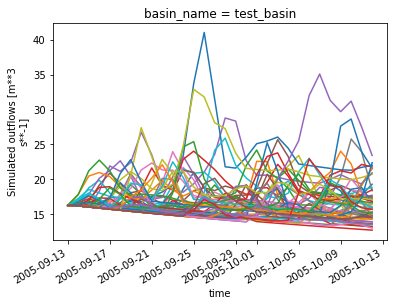

In [3]:
# The model has run! We can get the response.
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy them locally.
[forecast_url] = resp.get(asobj=False)
[forecast] = resp.get(asobj=True)
lines = forecast.q_sim.plot(hue="member", add_legend=False)

In [4]:
forecast.q_sim.isel(time=-1)

<xarray.DataArray 'q_sim' (member: 56)>
array([19.282085, 13.573855, 14.982147, 12.696147, 21.521354, 15.058527,
       15.710255, 18.346974, 16.347582, 15.994683, 21.985199, 17.31471 ,
       14.488165, 21.753123, 17.699051, 17.469094, 15.860713, 14.77492 ,
       15.000856, 18.788374, 14.768042, 14.63275 , 13.245731, 18.474389,
       13.872081, 14.690029, 15.057275, 15.933271, 14.501414, 13.53936 ,
       21.575939, 21.63954 , 17.249321, 13.177196, 13.896597, 15.315324,
       17.005341, 14.634705, 20.710227, 13.538029, 16.647485, 15.906462,
       16.592701, 16.816116, 23.415494, 13.609203, 12.985438, 20.908805,
       17.069509, 15.959013, 22.37186 , 14.229562, 15.174426, 15.663554,
       13.525553, 14.461007])
Coordinates:
    basin_name  object ...
    time        datetime64[ns] 2005-10-12
  * member      (member) int64 1954 1955 1956 1957 1958 ... 2007 2008 2009 2010
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

## Compute the forecast scores

There are different metric to evaluate the performance of forecasts. As an example, here we are computing the CRPS metric, using the [xskillscore](https://xskillscore.readthedocs.io/en/stable/) library server-side. 

In [5]:
# Here we are extracting the observed streamflow from the original timeseries to
# allow comparing both. also writing the data to a temporary netcdf file.
ds = xr.open_dataset(ts)
q_obs = ds.qobs.sel(time=slice(fdate, fdate + dt.timedelta(days=duration-1)))
q_obs_fn = tmp / 'q_obs.nc'
q_obs.to_netcdf(q_obs_fn)

In [6]:
# Now let's run XSkillScore
resp = wps.hindcast_evaluation(obs=str(tmp / 'q_obs.nc'), 
                               hcst=resp.get()[0], 
                               obs_var='qobs', 
                               hcst_var='q_sim', 
                               metric='crps_ensemble')
[score] = resp.get(asobj=True)
print(score)

<PreparedRequest [POST]>
<PreparedRequest [GET]>
{'crps_ensemble': 5.902283691705891}


## Graphics

The raven server bundles basic graphing capability, here we use the `graph_forecast_uncertainty` process to display the results.

<PreparedRequest [POST]>


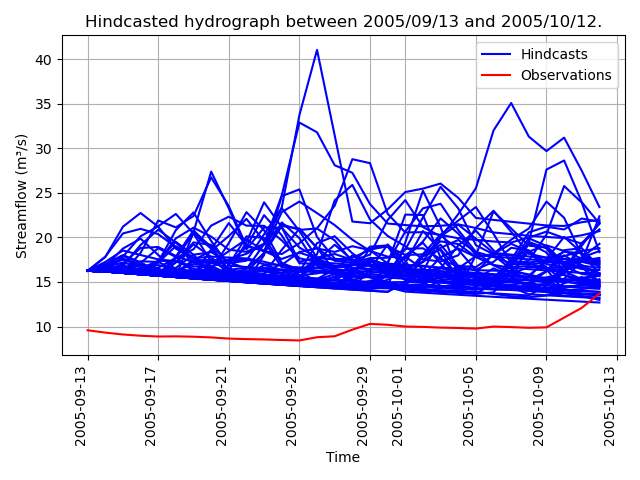

In [7]:
# And we can create a figure comparing the forecasts with the observations. 
resp = wps.graph_forecast_uncertainty(fcst=forecast_url, qobs=q_obs_fn, qobs_var="qobs")
[graphic] = resp.get(asobj=True)
graphic